In [3]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.core.lightning import LightningModule
from torchmetrics import functional as FM
import matplotlib.pyplot as plt

### 1. data load

In [4]:
training_data = datasets.FashionMNIST(root="./data",train=True, download=True, transform=ToTensor())
test_data = datasets.FashionMNIST(root="./data",train=False, download=True, transform=ToTensor())
train_dataset, val_dataset = random_split(training_data, [55000, 5000])

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



In [5]:
learning_rate = 1e-3
batch_size = 64
epochs = 10

In [6]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size) # 64
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

### 2. Model build

In [12]:
class Lightmodel_customed(LightningModule):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 512),
            torch.nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 256),
            torch.nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 64),
            torch.nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 10)
        )
    
    def forward(self, x): # 연산 순서에 대해 정의하는 부분인데 애초에 위에서 self.model = ~ 를 순서대로 작성해놓아서 이렇게만해도가능
        return self.model(x)
    
    def training_step(self, batch, batch_idx): # 학습 루프의 body 를 나타냄. loss return.
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        return loss
    
    def validation_step(self, batch, batch_idx): # 학습 중간에 모델 성능 체크 용도
        x, y = batch
        pred_y = self(x)
        acc = FM.accuracy(pred_y, y)
        loss = F.cross_entropy(pred_y, y)
        metrics = {'val_acc': acc, 'val_loss': loss}
        self.log_dict(metrics) # 하나의 값을 표시할 때는 self.log(<변수 이름="">, <값>)
        
    def test_step(self, batch, batch_idx) : # test 성능 체크용. 제공되는 batch 데이터만 다르고 코드는 validatipn_step과 동일
        x, y = batch
        pred_y = self(x)
        acc = FM.accuracy(pred_y, y)
        loss = F.cross_entropy(pred_y, y)
        metrics = {'val_acc': acc, 'val_loss': loss}
        self.log_dict(metrics)
        
    def configure_optimizers(self): # optimizer와 scheduler 구현
        return torch.optim.Adam(self.parameters(), lr=learning_rate)     

**test_dataloaders가 아니라 dataloaders로 변경된듯?!**

In [14]:
model = Lightmodel_customed()
trainer = Trainer(max_epochs=epochs, gpus=0) # 0 : cpu, 1 : gpu, 2이상 : 다중 gpu
trainer.fit(model, train_dataloader, val_dataloader)
# trainer.test(test_dataloaders=test_dataloader)
trainer.test(dataloaders=test_dataloader)

c:\Users\SeoJeongBin\miniconda3\envs\kotorch\lib\site-packages\pytorch_lightning\core\lightning.py:22: LightningDeprecationWarning: pytorch_lightning.core.lightning.LightningModule has been deprecated in v1.7 and will be removed in v1.9. Use the equivalent class from the pytorch_lightning.core.module.LightningModule class instead.
  rank_zero_deprecation(
c:\Users\SeoJeongBin\miniconda3\envs\kotorch\lib\site-packages\pytorch_lightning\trainer\connectors\accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=0)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=0)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 552 K 
-------------------------------------
552 K     Trainable params
0     

Sanity Checking: 0it [00:00, ?it/s]

c:\Users\SeoJeongBin\miniconda3\envs\kotorch\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:236: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\SeoJeongBin\miniconda3\envs\kotorch\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:236: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
c:\Users\SeoJeongBin\miniconda3\envs\kotorch\lib\site-packages\pytorch_lightning\trainer\trainer.py:1386: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  rank_zero_warn(
Restoring states from the checkpoint path at c:\Users\SeoJeongBin\Desktop\작업\KoGPT2_ChatBot\Pytorch_lightning\lightning_logs\version_1\checkpoints\epoch=9-step=8600.ckpt
Loaded model weights from checkpoint at c:\Users\SeoJeongBin\Desktop\작업\KoGPT2_ChatBot\Pytorch_lightning\lightning_logs\version_1\checkpoints\epoch=9-step=8600.ckpt
c:\Users\SeoJeongBin\miniconda3\envs\kotorch\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:236: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers w

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.8772000074386597
        val_loss            0.4312998652458191
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_acc': 0.8772000074386597, 'val_loss': 0.4312998652458191}]

### 3. Visualize

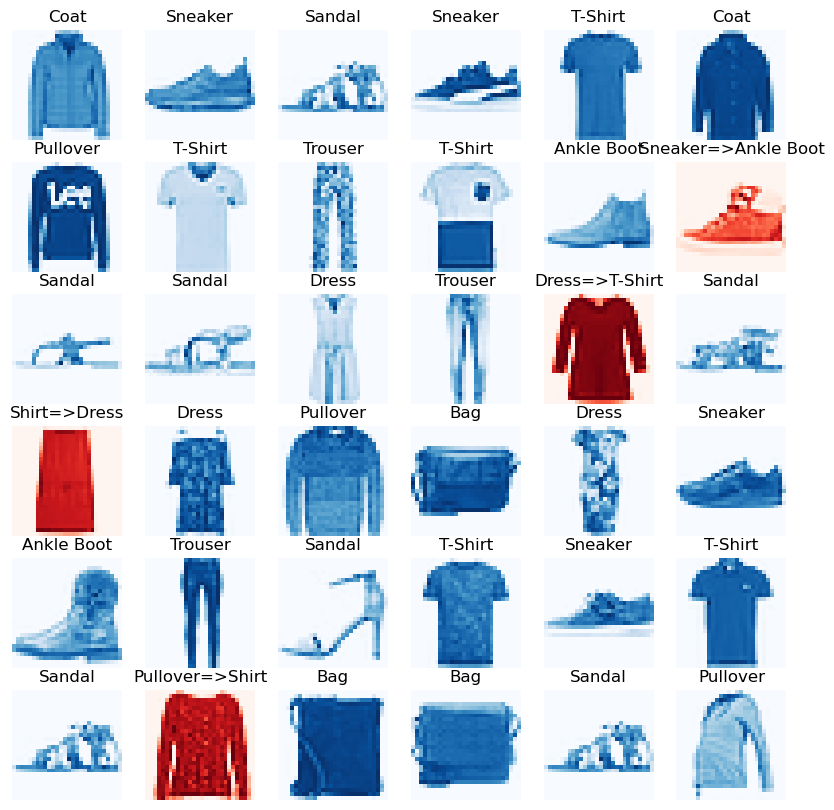

In [15]:
label_tags = {
    0: 'T-Shirt', 
    1: 'Trouser', 
    2: 'Pullover', 
    3: 'Dress', 
    4: 'Coat', 
    5: 'Sandal', 
    6: 'Shirt',
    7: 'Sneaker', 
    8: 'Bag', 
    9: 'Ankle Boot'
}
columns = 6
rows = 6
fig = plt.figure(figsize=(10,10))

model.eval()
for i in range(1, columns*rows+1):
    data_idx = torch.randint(len(test_dataloader),(1,)).item()
    input_img = test_data[data_idx][0].unsqueeze(dim=0)

    output = model(input_img)
    _, argmax = torch.max(output, 1)
    pred = label_tags[argmax.item()]
    label = label_tags[test_data[data_idx][1]]

    fig.add_subplot(rows, columns, i)
    if pred == label:
        plt.title(pred)
        cmap = 'Blues'
    else:
        plt.title(pred + '=>' +  label)
        cmap = 'Reds'
    plot_img = test_data[data_idx][0][0,:,:]
    plt.imshow(plot_img, cmap=cmap)
    plt.axis('off')

plt.show() 